Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.display import display


Preparing Data

In [2]:
# Load data
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)

# Select stocks to use; exclude the first column (date)
selected_stocks = prices_df.columns[1:51]

# Calculate returns
returns_df = prices_df[selected_stocks].pct_change()
returns_df = returns_df.dropna().reset_index(drop=True)
returns_df.insert(0, 'Date', prices_df['Date'][:-1])

# Convert to numpy array (for later calculations)
returns_matrix = returns_df.iloc[:, 1:].to_numpy()


Defining Parameters

-objasnjenje- train je do starta, test od starta do enda
(godina-mjesec-dan)
min datum je 2000-01-04
max datum je 2021-07-16

In [3]:
global windows, foreacast_horizon, test_start, test_end

windows = [21, 63, 126, 252] # month, quarter, half-year, year
forecast_horizon = 21 # trading days
test_start_date = pd.to_datetime('2000-01-03')
test_end_date = pd.to_datetime('2021-07-15')

messages = {"test_start": [], "test_end": []}

# Check if test_start_date exists in the DataFrame, if not, take the next date that exists
if test_start_date not in returns_df['Date'].values:
    test_start_date = returns_df['Date'][returns_df['Date'] > test_start_date].bfill().iloc[0]
    messages["test_start"] = messages["test_start"] or ['Start date not found, using closest next date instead.']

# Check if test_end_date exists in the DataFrame, if not, take the previous date that exists
if test_end_date not in returns_df['Date'].values:
    test_end_date = returns_df['Date'][returns_df['Date'] < test_end_date].ffill().iloc[-1]
    messages["test_end"] = messages["test_end"] or ['End date not found, using closest date instead.']

test_start = returns_df.loc[returns_df['Date'] == test_start_date].index[0]
test_end = returns_df.loc[returns_df['Date'] == test_end_date].index[0]

if test_start < max(windows):
    test_start = max(windows)
    messages["test_start"] = messages["test_start"] or ['Start date too early, not enough data for training.']

if test_end > len(returns_df) - forecast_horizon:
    test_end = len(returns_df) - forecast_horizon
    messages["test_end"] = messages["test_end"] or ['End date too late, not enough data for testing.']
    
if (test_end - test_start) % forecast_horizon != 0:
    test_end = test_end - (test_end - test_start) % forecast_horizon
    messages["test_end"] = messages["test_end"] or ['End date not a multiple of forecast horizon.']

if messages["test_start"]:
    print('Adjusted tart date: {}. Reason: {}'.format(returns_df['Date'][test_start], ' '.join(messages["test_start"])))
if messages["test_end"]:
    print('Adjusted end date: {}. Reason: {}'.format(returns_df['Date'][test_end], ' '.join(messages["test_end"])))

del test_start_date, test_end_date, messages

Adjusted tart date: 2001-01-02 00:00:00. Reason: Start date too early, not enough data for training.
Adjusted end date: 2021-06-04 00:00:00. Reason: End date too late, not enough data for testing.


Naive Risk Parity

-objasnjenje- (inv_volatilities = inverse volatilnosti)

In [4]:
def get_portfolio_weights(volatility):
    inv_volatilities = np.array([1/volatility[stock] if volatility[stock] > 0 else 0 for stock in selected_stocks])
    total = np.sum(inv_volatilities)
    return inv_volatilities / total if total > 0 else np.zeros(len(selected_stocks))

In [5]:
methods = defaultdict(lambda: defaultdict(list))

def gather_portfolio_metrics(method, i, volatility):
    # Record predicted volatility for each stock
    methods[method]["predicted volatility"].extend({stock: [volatility[stock]] for stock in selected_stocks})
        
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)
    
    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    methods[method]["returns"].extend(returns)


Sample Method

In [6]:
method = "Sample"

for window in windows:
    for i in range(test_start, test_end, forecast_horizon):
        # 
        volatility = {stock: returns_df[stock][i - window: i].std() for stock in selected_stocks}

        gather_portfolio_metrics(method + "-" + str(window), i, volatility)

Perfect Prediction Method

In [7]:
method = "PerfectPrediction"

for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std() for stock in selected_stocks}

    gather_portfolio_metrics(method, i, volatility)

Equal Weight Method

In this approach, we are assuming that all stocks have the same volatility. This assumption simplifies our model by allowing us to assign equal weights to all stocks in the portfolio. However, it's important to note that this is a simplification. In reality, different stocks may have different volatilities, which could impact the optimal portfolio allocation.

In [8]:
method = "EqualWeight"

for i in range(test_start, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in selected_stocks}

    gather_portfolio_metrics(method, i, volatility)

Exponential Weight Method

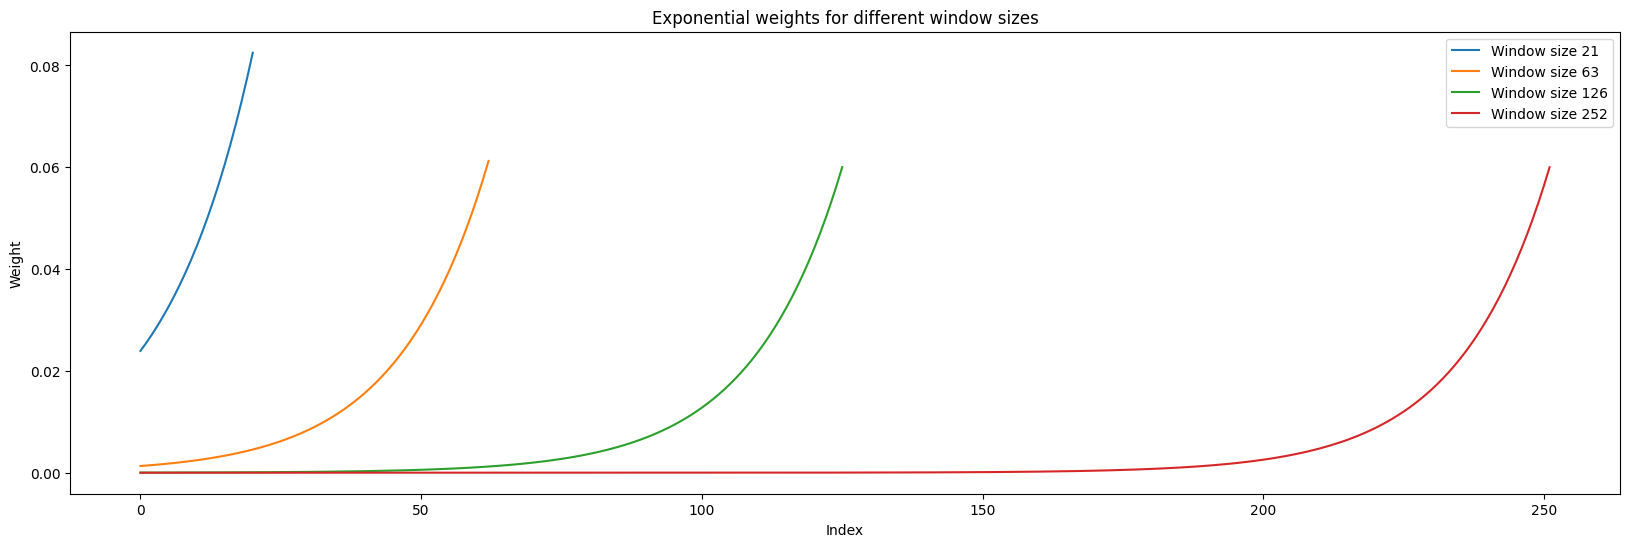

In [9]:
def get_exponential_weights(size, const=0.94):
    weights = [const**i for i in range(size, 0, -1)]
    total = sum(weights)
    return [weight / total for weight in weights]
    
plt.figure(figsize=(20, 6))
for window in windows:
    weights = get_exponential_weights(window)
    plt.plot(weights, label=f'Window size {window}')
plt.title('Exponential weights for different window sizes')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [10]:
method = "ExponentialWeight"

def get_weighted_volatility(weights, returns):
    variance = sum(weights * returns**2)
    return variance**0.5

for window in windows:
    weights = get_exponential_weights(window)
    for i in range(test_start, test_end, forecast_horizon):
        # 
        volatility = {stock: get_weighted_volatility(weights, returns_df[stock][i - window: i]) for stock in selected_stocks}

        gather_portfolio_metrics(method + "-" + str(window), i, volatility)

Least Squares Linear Regression Method

In [11]:
global window, train_start, train_end
window = 21 # Set window to 21 days from now on for computational efficiency
train_start = window + test_start % forecast_horizon # Training start is divisible by forecast_horizon
train_end = test_start - forecast_horizon # Training end is one forecast_horizon before testing start

def get_linear_regression_model(A, B):
    # Fit a linear regression model with non-negative coefficients and no intercept
    model = LinearRegression(positive=True, fit_intercept=False)
    model.fit(np.array(A), np.array(B))

    return model

Linear Regression (return^2, variance)

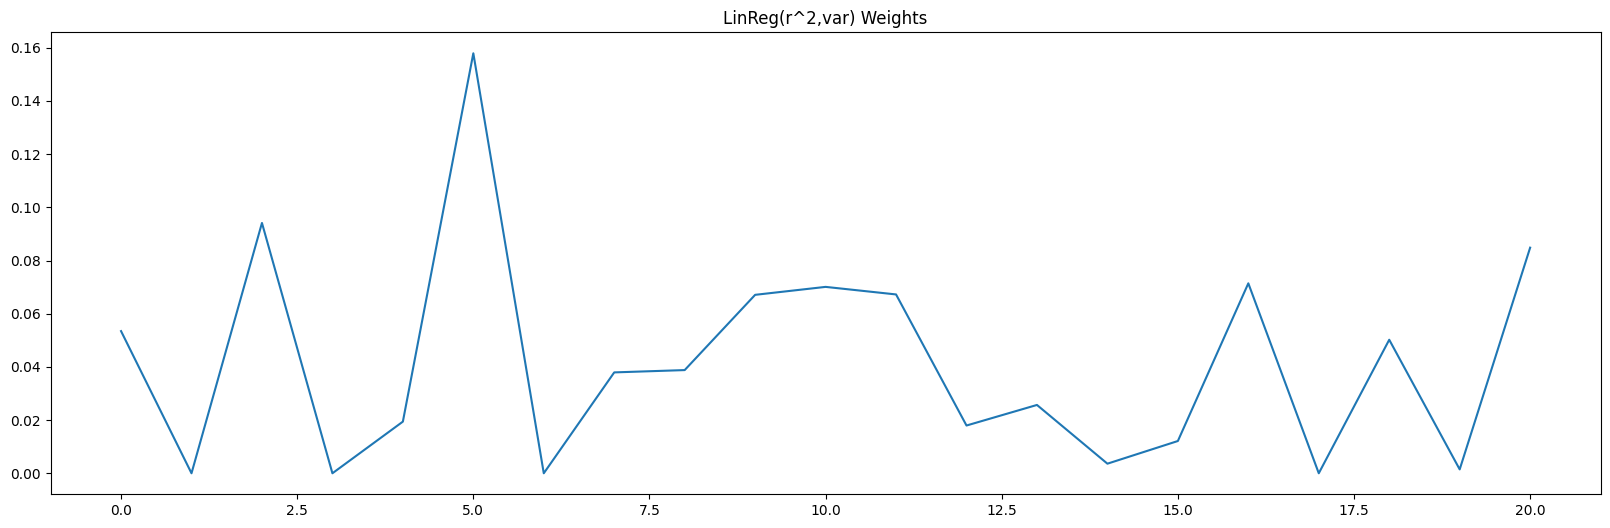

In [12]:
A, B = [], []
# Iterate over each window of returns
for i in range(train_start, train_end, forecast_horizon):
    for stock in selected_stocks:
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

methods["LinReg(r^2,var)"]["model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
plt.plot(methods["LinReg(r^2,var)"]["model"].coef_)
plt.title("LinReg(r^2,var) Weights")
plt.show()

In [13]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: methods["LinReg(r^2,var)"]["model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)**0.5 for stock in selected_stocks}

    gather_portfolio_metrics(method + "-" + str(window), i, volatility)

Individual Linear Regression (return^2, variance)

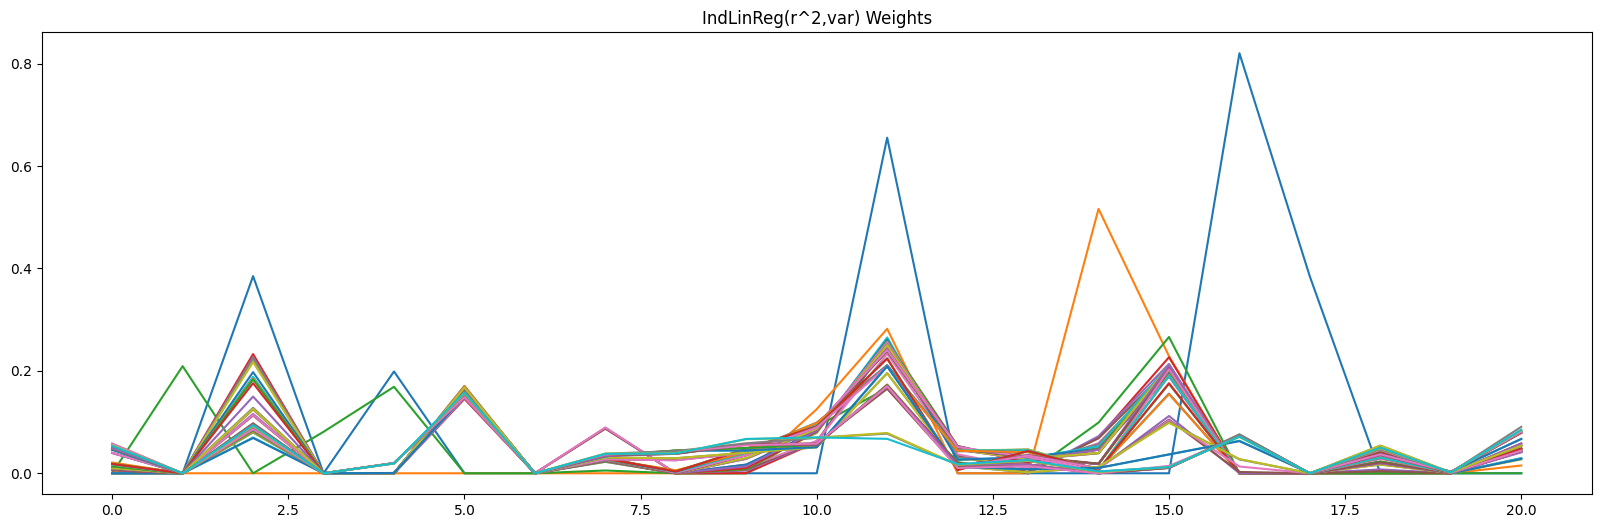

In [14]:
A, B = [], []
# Store individual models for each stock
for stock in selected_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

    methods["IndLinReg(r^2,var)"][stock+"model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
for stock in selected_stocks:
    plt.plot(methods["IndLinReg(r^2,var)"][stock+"model"].coef_)
plt.title("IndLinReg(r^2,var) Weights")
plt.show()

In [15]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: methods["IndLinReg(r^2,var)"][stock+"model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)**0.5 for stock in selected_stocks}

    gather_portfolio_metrics(method + "-" + str(window), i, volatility)

Portfolios' Performances

In [17]:
for portfolio in methods.values():
    print(portfolio["returns"])

[0.02879013837731366, -0.01783216943699193, -0.016099823275740582, -0.0019243890271162581, 0.0022365447629677463, 0.0016708461189651118, 0.003702061125911782, -0.0015534278453288271, 0.006177858101297372, -0.006022473869297277, 0.010598716956128169, -0.008267207156769932, 0.006254080530550516, 0.005530033678228909, -0.002966553671380184, 0.0031620042609143283, -0.0008367780041304989, 0.005503048569547704, 0.008610872710641992, 0.0028233297959376533, 0.005548100612793297, -0.009109196999827327, 0.002603886081830397, 0.0029999962600263156, -0.006192934984608166, -0.0031018794594512124, -0.008910352506539841, 0.013862309299448858, -0.006497229701713125, -0.004902577556136196, 0.0036835796168373084, -0.006008095291154892, -0.010384739072652175, -0.014225715087089648, -0.004659525746796321, -0.005526005355011866, 0.019740633008086463, -0.0072802180150614085, -0.015917837935592906, -0.001604090485232339, -0.002013525010494721, 0.005603783028778885, 0.003297109119367667, 0.00607186656631713, 

In [16]:
portfolios_df = {
    "Portfolio": [method for method in methods],
    "Std": [np.std(portfolio["returns"]) * 252**0.5 for portfolio in methods.values()],
    "Return": [(1 + np.average(portfolio["returns"]))**252 - 1 for portfolio in methods.values()],
    "Sharpe": [((1 + np.average(portfolio["returns"]))**252 - 1) / (np.std(portfolio["returns"]) * 252**0.5) for portfolio in methods.values()]
}

display(pd.DataFrame(portfolios_df).sort_values('Sharpe', ascending=False).reset_index(drop=True))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15561,) + inhomogeneous part.

Portfolio Value (initial investment: 1$)

In [ ]:
for portfolio in methods.values():
    portfolio["value"] = []
    portfolio["value"].append(1) # Starting value of 1($)
    for ret in portfolio["returns"]:
        portfolio["value"].append((ret+1)*portfolio["value"][-1])

dates = returns_df.iloc[test_start:test_end + forecast_horizon + 1, 0]
sorted_methods = sorted(methods.items(), key=lambda method: method[1]["value"][-1], reverse=True)

plt.figure(figsize=(20, 6))
for method, portfolio in sorted_methods:
    plt.semilogy(dates, portfolio["value"], label=method)
plt.title("All Portfolios Performance")
plt.legend()
plt.show()

In [ ]:
#del window, i, volatility, method, start, end, forecast_horizon, windows, selected_stocks, A, B